In [90]:
import torch  # type: ignore
import pyro  # type: ignore
import pyro.distributions as dist  # type: ignore
from pyro.optim import Adam  # type: ignore
from pyro.infer import SVI, Trace_ELBO  # type: ignore
from pyro.infer import MCMC, NUTS, HMC, RandomWalkKernel  # type: ignore
from torch.distributions import constraints  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
import scipy  # type: ignore
import numpy as np  # type: ignore
import tqdm  # type: ignore
import pyro.poutine as poutine  # type: ignore
from statsmodels.graphics import tsaplots # type: ignore
import pandas as pd # type: ignore

plt.style.use('seaborn-v0_8-darkgrid')

# Markov Chain Monte Carlo

We want to approximate the posterior distribution 
$$p(z\mid x) = \frac{p(x\mid z)p(z)}{\int p(x\mid z)p(z) dz}$$ 
by samples:

$$z_n\sim p(z\mid x)$$
$$\hat p(z\mid x) = \frac{1}{N}\sum_{n=1}^N \delta(z_n-z)$$

The challenge lies in obtaining samples from the posterior distribution. One approach is to use a Markov Chain with a limiting distribution that matches the posterior distribution. Given that a Markov Chain is defined by its initial distribution (the prior) and its Markov kernel (conditional distributions), the distinguishing factor between different MCMC methods is the construction of the kernel.

# Pyro VI Example (1)

Implementing Markov Chain Monte Carlo (MCMC) with Pyro involves three key components: the model, the kernel, and the MCMC sampler.

1. **Model Function:**
   The model function defines the probabilistic model using the input data:

   - **Latent Variables:**
     Define latent variables with their respective prior distributions:
     ```python
     z_prior = dist.name_of_prior_distribution()
     z = pyro.sample('z', z_prior)
     ```

   - **Likelihood Function:**
     Specify the likelihood function for the observed data:
     ```python
     with pyro.plate('data', len(data)):
         pyro.sample('obs', dist.name_of_likelihood_distribution(), obs=data)
     ```
     For a comprehensive list of distributions, refer to the [Pyro Distributions Documentation](https://docs.pyro.ai/en/stable/distributions.html).

2. **Kernel Function:**
   The kernel function specifies the MCMC algorithm to be used:

   - **Hamiltonian Monte Carlo (HMC):**
     ```python
     kernel = HMC(model, step_size=float, num_steps=int)
     ```

   - **No-U-Turn Sampler (NUTS):**
     NUTS is an efficient variant of HMC.
     ```python
     kernel = NUTS(model, step_size=float, max_tree_depth=int)
     ```

   - **Random Walk Kernel:**
     This is a simple, gradient-free kernel using an isotropic Gaussian random walk in the unconstrained latent space of the model.
     ```python
     kernel = RandomWalkKernel(model, init_step_size=float, target_accept_prob=float)
     ```

3. **MCMC Sampling:**

   - **MCMC Initialization:**
     Create an MCMC instance with a specified number of samples and warm-up (burn-in) steps:
     ```python
     mcmc = MCMC(kernel, num_samples=int, warmup_steps=int)
     ```

   - **Running MCMC and Extracting Samples:**
     Perform the MCMC sampling and retrieve the posterior samples:
     ```python
     mcmc.run(data)
     posterior_samples = mcmc.get_samples()
     ```

### Example
Consider a model where $p(x \mid z) \sim \mathcal{N}(z, 1)$

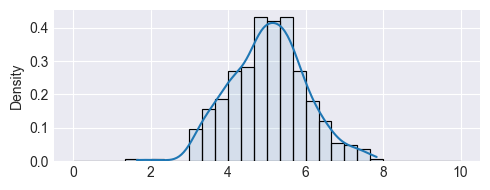

In [46]:
# Example data
true_mean=5
true_std=1
n_data_samples=500
x = true_mean + true_std*torch.randn(n_data_samples)# Generate n_samples random noisy data points with mean 5 and standard deviation 1

# Plotting the histogram of the data
plt.figure(figsize=(5, 2))  # Set the figure size
sns.histplot(x, binrange=(0,10), bins=30, kde=True, stat='density', alpha=0.1)  # Plot the histogram with KDE
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()  # Display the plot

In [47]:
def model(data):
    z_prior = dist.Normal(0.0, 1.0)  # Normal prior distribution over z
    z = pyro.sample('z', z_prior)  # Sample z from the prior distribution
    # Posterior
    with pyro.plate('data', len(data)):
        pyro.sample('obs', dist.Normal(z, 1), obs=data)

def log_true_posterior(z,x):
    return torch.sum(-0.5*torch.square((x-z)))-0.5*torch.square(z)

What about the true posterior $p(z\mid x_{1:n})$?

$$p(z\mid x_{1:n})= \frac{\prod_{i=1}^n \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}\left(x_{i}-z\right)^2\right)\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}z^2\right)}{\int \frac{1}{\sqrt{2\pi}\sigma}\prod_{i=1}^n\exp\left(-\frac{1}{2}\left(x_{i}-z\right)^2\right) dz}\propto \prod_{i=1}^n\exp\left(-\frac{1}{2}\left(x_{i}-z\right)^2\right)\exp\left(-\frac{1}{2}z^2\right)$$

# Random Walk Kernel

In [48]:
rw_kernel = RandomWalkKernel(model, init_step_size=.1, target_accept_prob=0.2)
mcmc = MCMC(rw_kernel, num_samples=1000, warmup_steps=100)
mcmc.run(x)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 1100/1100 [00:00, 3872.56it/s, step size=1.50e-01, acc. prob=0.335]


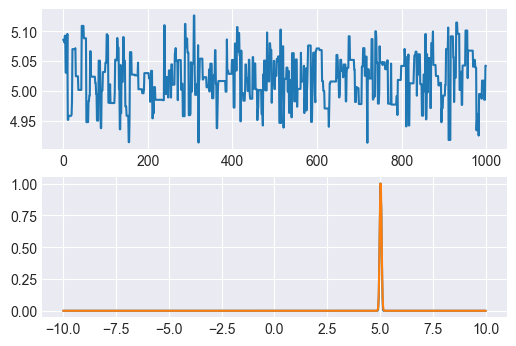

In [49]:
z=torch.linspace(-10, 10, 1000)

fig,ax=plt.subplots(2,1,figsize=(6,4))
plt.sca(ax[0])
plt.plot(posterior_samples['z'])

kde = scipy.stats.gaussian_kde(posterior_samples['z'])
y1 = kde.pdf(z)
y1/=y1.max()

plt.sca(ax[1])
log_p=torch.tensor([log_true_posterior(_z,x) for _z in z])
log_p-=log_p.max()
true_post_p=torch.exp(log_p)
true_post_p/=true_post_p.max()
plt.plot(z, y1)
plt.plot(z, true_post_p)

plt.show()

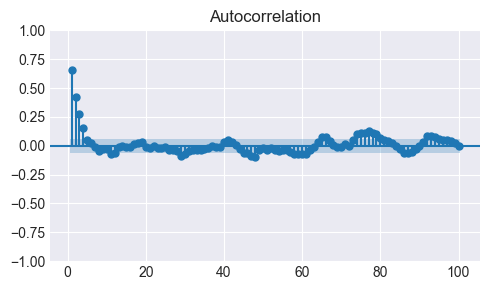


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         z      5.02      0.04      5.02      4.95      5.08    241.69      1.00



In [50]:
#plot autocorrelation function
fig, ax=plt.subplots(1,1,figsize=(5,3))
tsaplots.plot_acf(posterior_samples['z'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, ax=ax)
plt.tight_layout()
plt.show()
mcmc.summary()

# Hamiltonian Monte Carlo (HMC)

In [51]:
hmc_kernel = HMC(model, step_size=0.01, num_steps=10)
mcmc = MCMC(hmc_kernel, num_samples=1000, num_chains=1, warmup_steps=10)
mcmc.run(x)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 1010/1010 [00:00, 2484.56it/s, step size=5.84e-02, acc. prob=0.830]


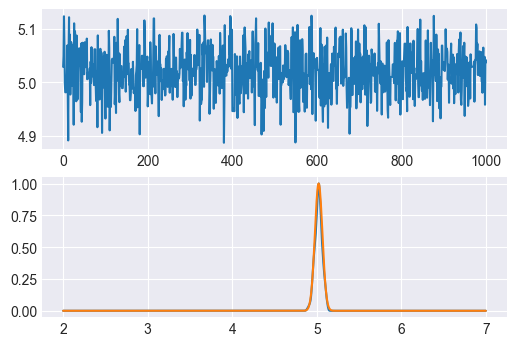

In [52]:
z=torch.linspace(2, 7, 1000)

fig,ax=plt.subplots(2,1,figsize=(6,4))
plt.sca(ax[0])
plt.plot(posterior_samples['z'])

kde = scipy.stats.gaussian_kde(posterior_samples['z'])
y1 = kde.pdf(z)
y1/=y1.max()

plt.sca(ax[1])
log_p=torch.tensor([log_true_posterior(_z,x) for _z in z])
log_p-=log_p.max()
true_post_p=torch.exp(log_p)
true_post_p/=true_post_p.max()
plt.plot(z, y1)
plt.plot(z, true_post_p)

plt.show()

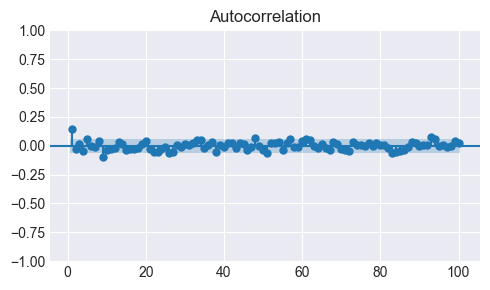


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         z      5.02      0.04      5.02      4.95      5.09    772.68      1.00

Number of divergences: 0


In [53]:
#plot autocorrelation function
fig, ax=plt.subplots(1,1,figsize=(5,3))
tsaplots.plot_acf(posterior_samples['z'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, ax=ax)
plt.tight_layout()
plt.show()
mcmc.summary()

# NUTS kernel

In [54]:
hmc_kernel = NUTS(model, step_size=0.01, max_tree_depth=1)
mcmc = MCMC(hmc_kernel, num_samples=1000, warmup_steps=10)
mcmc.run(x)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 1010/1010 [00:00, 2158.21it/s, step size=4.01e-02, acc. prob=0.946]


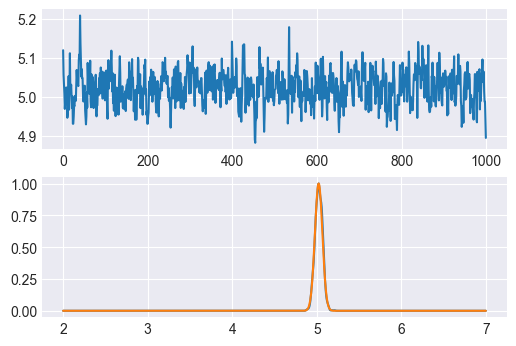

In [55]:
z=torch.linspace(2, 7, 1000)

fig,ax=plt.subplots(2,1,figsize=(6,4))
plt.sca(ax[0])
plt.plot(posterior_samples['z'])

kde = scipy.stats.gaussian_kde(posterior_samples['z'])
y1 = kde.pdf(z)
y1/=y1.max()

plt.sca(ax[1])
log_p=torch.tensor([log_true_posterior(_z,x) for _z in z])
log_p-=log_p.max()
true_post_p=torch.exp(log_p)
true_post_p/=true_post_p.max()
plt.plot(z, y1)
plt.plot(z, true_post_p)

plt.show()

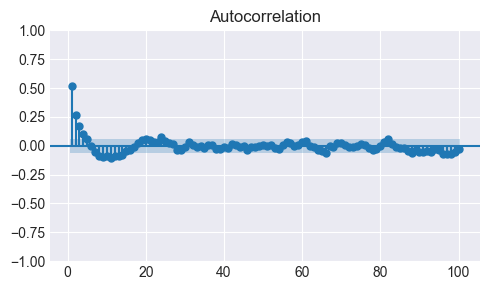


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         z      5.02      0.04      5.02      4.95      5.09    309.12      1.00

Number of divergences: 0


In [56]:
#plot autocorrelation function
fig, ax=plt.subplots(1,1,figsize=(5,3))
tsaplots.plot_acf(posterior_samples['z'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, ax=ax)
plt.tight_layout()
plt.show()
mcmc.summary()

# METROPOLIS HASTINGS

In [57]:
n_samples=10000
step_size=0.1
warmup_steps=100

posterior_samples={'z': torch.zeros(warmup_steps+n_samples+1)}
posterior_samples['z'][0]=torch.randn((1,))

for idx in tqdm.tqdm(range(warmup_steps+n_samples)):
    current_params = {'z': posterior_samples['z'][idx]}
    log_prob_current = poutine.trace(pyro.poutine.condition(model, current_params)).get_trace(x).log_prob_sum().item()

    proposed_params={'z': posterior_samples['z'][idx]+step_size*torch.randn((1,))}

    log_prob_proposed = poutine.trace(pyro.poutine.condition(model, proposed_params)).get_trace(x).log_prob_sum().item()
    log_acceptance_ratio = log_prob_proposed - log_prob_current

    if torch.rand(1).log().item() < log_acceptance_ratio:
        posterior_samples['z'][idx+1]=proposed_params['z']
    else:
        posterior_samples['z'][idx+1]=posterior_samples['z'][idx]

posterior_samples['z'] = posterior_samples['z'][warmup_steps:]

100%|██████████| 10100/10100 [00:03<00:00, 2970.87it/s]


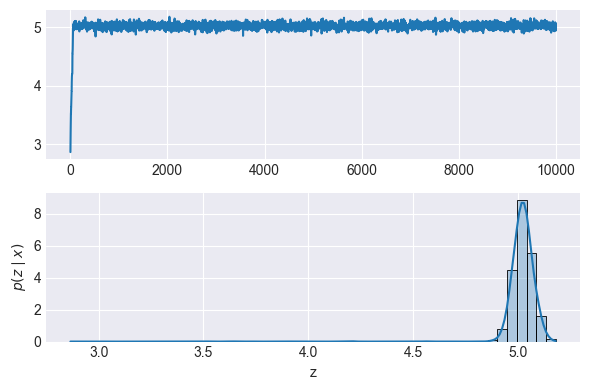

In [58]:
fig,ax=plt.subplots(2,1,figsize=(6,4))
plt.sca(ax[0])
plt.plot(posterior_samples['z'])

plt.sca(ax[1])
sns.histplot(posterior_samples['z'], bins=50, kde=True, fill=True, stat='density', alpha=0.3)
plt.xlabel('z')
plt.ylabel(r'$p(z\mid x)$')

plt.tight_layout()
plt.show()

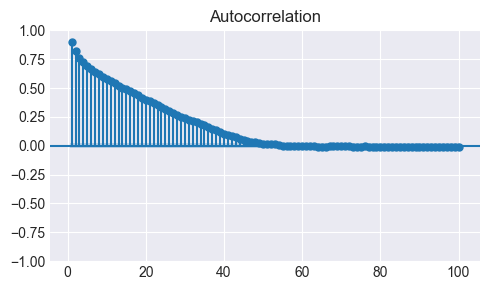


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         z      5.02      0.04      5.02      4.95      5.09    309.12      1.00

Number of divergences: 0


In [59]:
#plot autocorrelation function
fig, ax=plt.subplots(1,1,figsize=(5,3))
tsaplots.plot_acf(posterior_samples['z'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, ax=ax)
plt.tight_layout()

plt.show()
mcmc.summary()

# Linear Regression

$ y = ax + \varepsilon $

$ \varepsilon \sim \mathcal{N}(0,\sigma^2)$

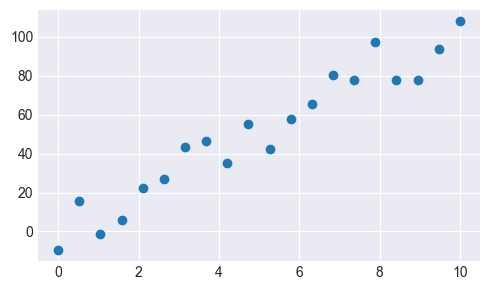

In [83]:
torch.manual_seed(2)

a = 10
b = 1
x = torch.linspace(0,10,20)
y = a*x + b + 10*torch.randn(x.shape[0])

plt.figure(figsize=(5,3))
plt.scatter(x,y)
plt.tight_layout()
plt.show()

LS a:  tensor(10.2914)  --- LS b:  tensor(-0.5021)


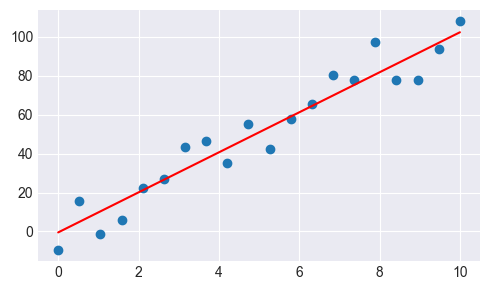

In [84]:
# Least Squares
a_hat = torch.matmul(x,x.T)**(-1) * torch.matmul(x.T,y)
b_hat = torch.mean(y - a_hat * x)

print('LS a: ', a_hat, ' --- LS b: ', b_hat)

plt.figure(figsize=(5,3))
plt.scatter(x,y)
plt.plot(x, a_hat*x + b_hat, color='red')
plt.tight_layout()
plt.show()

# MCMC

$p(y\mid a,b) \sim \mathcal{N}(ax+b, \sigma^2)$

In [223]:
def model(x, y, sigma_noise):
    # Define prior distributions for the latent variables
    z_a = pyro.sample("z_a", dist.Normal(0.0, 10.0))  # Slope
    z_b = pyro.sample("z_b", dist.Normal(0.0, 10.0))  # Intercept
    
    # Observation model
    with pyro.plate("data", len(y)):
        pyro.sample("obs", dist.Normal(z_a * x + z_b, sigma_noise), obs=y)

In [260]:
# Define the HMC kernel and MCMC sampling
hmc_kernel = HMC(model, step_size=2., num_steps=1)
mcmc = MCMC(hmc_kernel, num_samples=1000, num_chains=1, warmup_steps=1000)

# Run MCMC on the model
mcmc.run(x, y, sigma_noise=10)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 2000/2000 [00:03, 612.42it/s, step size=4.29e-01, acc. prob=0.918]


In [261]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       z_a     10.44      0.68     10.43      9.30     11.53    459.79      1.00
       z_b     -1.14      3.97     -1.10     -7.38      5.46    471.69      1.00

Number of divergences: 0


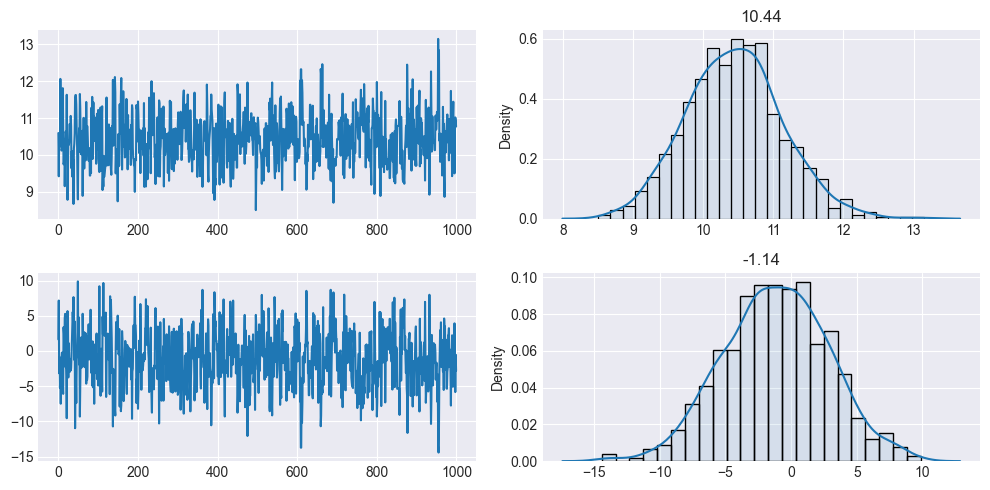

In [262]:
fig, ax = plt.subplots(2,2,figsize=(10,5))

plt.sca(ax[0,0])
plt.plot(posterior_samples['z_a'])

plt.sca(ax[0,1])
sns.histplot(posterior_samples['z_a'], stat='density', alpha=0.1)
sns.kdeplot(posterior_samples['z_a'])
plt.title(np.round(posterior_samples['z_a'].mean().item(), 2))

plt.sca(ax[1,0])
plt.plot(posterior_samples['z_b'])

plt.sca(ax[1,1])
sns.histplot(posterior_samples['z_b'], stat='density', alpha=0.1)
sns.kdeplot(posterior_samples['z_b'])
plt.title(np.round(posterior_samples['z_b'].mean().item(), 2))


plt.tight_layout()
plt.show()

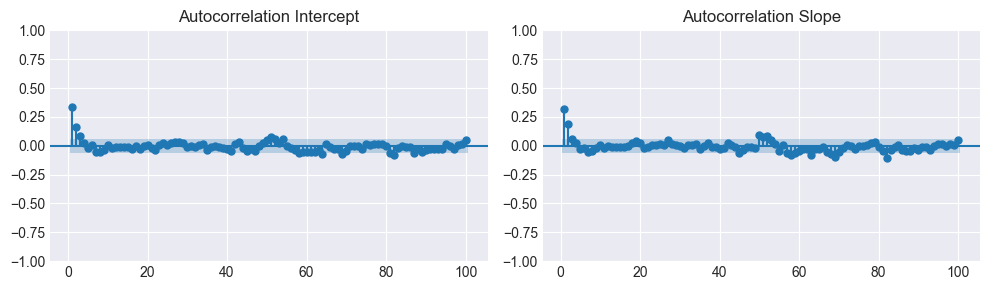

In [263]:
#plot autocorrelation function
fig, ax=plt.subplots(1,2,figsize=(10,3))
tsaplots.plot_acf(posterior_samples['z_a'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, title='Autocorrelation Intercept', ax=ax[0])
tsaplots.plot_acf(posterior_samples['z_b'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, title='Autocorrelation Slope', ax=ax[1])
plt.tight_layout()
plt.show()

# Add noise standard deviation

In [264]:
def model(x, y):
    # Define prior distributions for the latent variables
    z_a = pyro.sample("z_a", dist.Normal(0.0, 10.0))  # Slope
    z_b = pyro.sample("z_b", dist.Normal(0.0, 10.0))  # Intercept
    z_sigma = pyro.sample('z_sigma', dist.Gamma(2.0, 5.0))  # Noise std
    
    # Observation model
    with pyro.plate("data", len(y)):
        pyro.sample("obs", dist.Normal(z_a * x + z_b, z_sigma), obs=y)

In [269]:
# Define the HMC kernel and MCMC sampling
hmc_kernel = HMC(model, step_size=1., num_steps=2)
mcmc = MCMC(hmc_kernel, num_samples=1000, num_chains=1, warmup_steps=100)

# Run MCMC on the model
mcmc.run(x, y)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 1100/1100 [00:03, 294.25it/s, step size=4.85e-01, acc. prob=0.872]


In [270]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       z_a     10.54      0.45     10.55      9.85     11.30    656.01      1.00
       z_b     -1.54      2.54     -1.62     -5.67      2.72    670.09      1.00
   z_sigma      5.93      0.55      5.89      5.12      6.90   1018.85      1.00

Number of divergences: 0


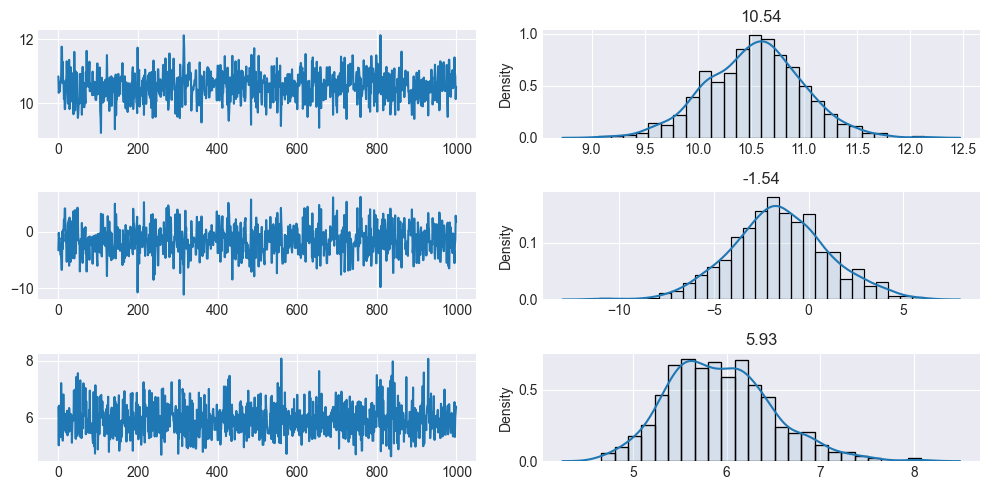

In [271]:
fig, ax = plt.subplots(3,2,figsize=(10,5))

plt.sca(ax[0,0])
plt.plot(posterior_samples['z_a'])

plt.sca(ax[0,1])
sns.histplot(posterior_samples['z_a'], stat='density', alpha=0.1)
sns.kdeplot(posterior_samples['z_a'])
plt.title(np.round(posterior_samples['z_a'].mean().item(), 2))

plt.sca(ax[1,0])
plt.plot(posterior_samples['z_b'])

plt.sca(ax[1,1])
sns.histplot(posterior_samples['z_b'], stat='density', alpha=0.1)
sns.kdeplot(posterior_samples['z_b'])
plt.title(np.round(posterior_samples['z_b'].mean().item(), 2))

plt.sca(ax[2,0])
plt.plot(posterior_samples['z_sigma'])

plt.sca(ax[2,1])
sns.histplot(posterior_samples['z_sigma'], stat='density', alpha=0.1)
sns.kdeplot(posterior_samples['z_sigma'])
plt.title(np.round(posterior_samples['z_sigma'].mean().item(), 2))


plt.tight_layout()
plt.show()

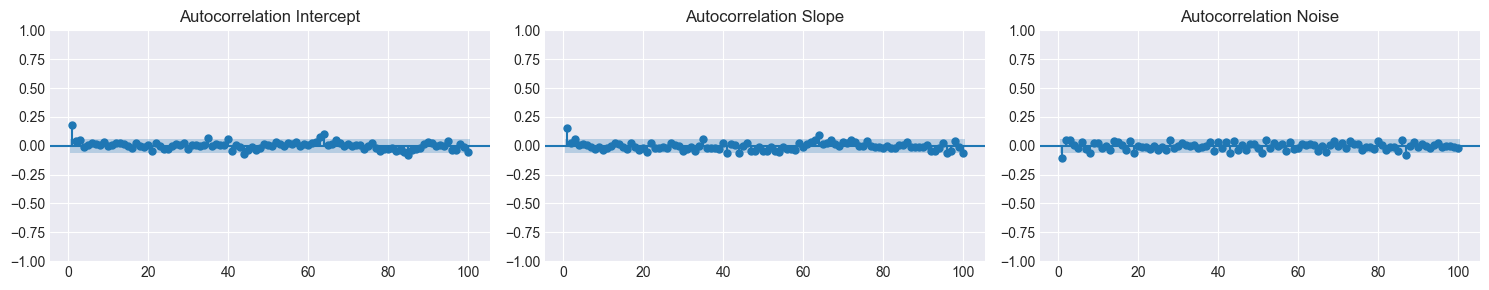

In [272]:
#plot autocorrelation function
fig, ax=plt.subplots(1,3,figsize=(15,3))
tsaplots.plot_acf(posterior_samples['z_a'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, title='Autocorrelation Intercept', ax=ax[0])
tsaplots.plot_acf(posterior_samples['z_b'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, title='Autocorrelation Slope', ax=ax[1])
tsaplots.plot_acf(posterior_samples['z_sigma'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, title='Autocorrelation Noise', ax=ax[2])
plt.tight_layout()
plt.show()

# Example

In [275]:
N=1000

In [273]:
def p(x,y):
    return np.exp(-10 * (x ** 2 - y) ** 2 - (y - 1 / 4) ** 4)

def proposal(x,y,sigma=0.01):
    return np.array([x, y]) + sigma*np.random.randn(2)

In [276]:
sigma = [0.005, 0.5, 5]
acc = np.zeros(np.size(sigma))
samples = [np.zeros((N,2)) for i in range(np.size(sigma))]

for sdx, _sig in enumerate(sigma):
    samples[sdx][0,:] = [-1,-1.5]
    for idx in range(N-1):
        _sam = samples[sdx][idx,:]
        x,y = proposal(_sam[0],_sam[1],sigma=_sig)
        if p(x,y) / p(_sam[0],_sam[1]) > np.random.rand():
            acc[sdx]+=1
            samples[sdx][idx+1,:] = np.array([x, y])
        else:
            samples[sdx][idx+1,:] = _sam

In [ ]:
z = np.zeros((len(sigma), N))
for sdx in range(len(sigma)):
    xy = np.vstack([samples[sdx][:,0],samples[sdx][:,1]])
    z[sdx,:] = scipy.stats.gaussian_kde(xy)(xy)

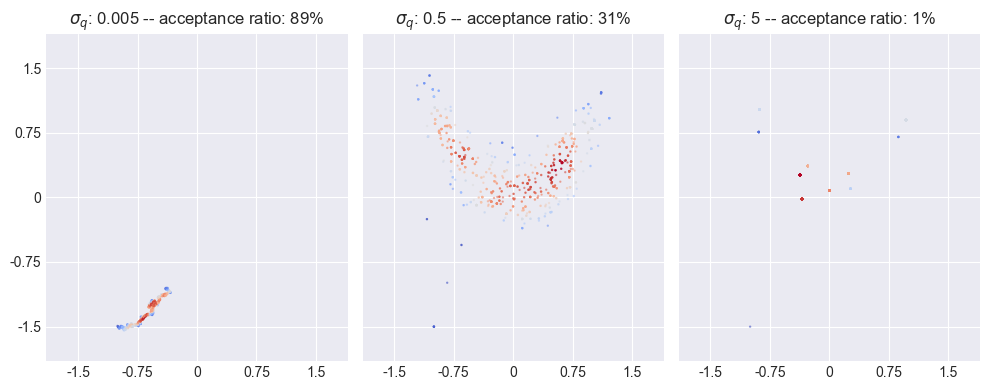

In [279]:
fig, ax = plt.subplots(1,3, figsize=(10,4), sharey='all')

for sdx, _sig in enumerate(sigma):
    plt.sca(ax[sdx])
    # Calculate the point density
    plt.scatter(samples[sdx][:,0], samples[sdx][:,1], marker='.', s=2, c=z[sdx,:], cmap='coolwarm', alpha=0.5)
    plt.title(fr'$\sigma_q$: {_sig} -- acceptance ratio: {int(100*acc[sdx]/N)}%')
    plt.yticks([-1.5,-0.75,0,0.75,1.5], ['-1.5','-0.75','0','0.75','1.5'])
    plt.xticks([-1.5,-0.75,0,0.75,1.5], ['-1.5','-0.75','0','0.75','1.5'])
    plt.xlim([-1.9,1.9])
    plt.ylim([-1.9,1.9])

plt.tight_layout()
plt.show()